In [ ]:
import os
import tarfile
import pickle
import requests
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from pathlib import Path
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

In [ ]:
# ==============================================================================
# STEP 1 & 2: DATA PREPARATION (download, unpack, save to folders)
# ==============================================================================
def download_and_unpack_cifar10():
    url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        print(f"Downloading dataset from {url}...")
        r = requests.get(url, stream=True)
        r.raise_for_status()
        with open(filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): f.write(chunk)
        print("Download complete.")
    if not os.path.exists("cifar-10-batches-py"):
        print(f"Extracting archive {filename}...")
        with tarfile.open(filename, "r:gz") as tar: tar.extractall()
        print("Extraction complete.")
download_and_unpack_cifar10()

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def create_image_file_structure():
    base_output_dir = Path('./my_cifar_data')
    if base_output_dir.exists():
        print(f"Folder structure '{base_output_dir}' already exists. Skipping creation.")
        return
    print("\nCreating user-friendly folder structure and saving images...")
    class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    for split in ['train', 'test']:
        for i, name in enumerate(class_names):
            (base_output_dir / split / f"{i}_{name}").mkdir(parents=True, exist_ok=True)
    train_image_idx = 0
    for i in range(1, 6):
        data_dict = unpickle(f'cifar-10-batches-py/data_batch_{i}')
        for j, (image_data, label) in enumerate(zip(data_dict[b'data'], data_dict[b'labels'])):
            img_pil = Image.fromarray(image_data.reshape(3, 32, 32).transpose(1, 2, 0))
            output_dir = base_output_dir / 'train' / f"{label}_{class_names[label]}"
            img_pil.save(output_dir / f"{train_image_idx}.png")
            train_image_idx += 1
    print(f"Saved {train_image_idx} training images.")
    test_image_idx = 0
    data_dict = unpickle('cifar-10-batches-py/test_batch')
    for j, (image_data, label) in enumerate(zip(data_dict[b'data'], data_dict[b'labels'])):
        img_pil = Image.fromarray(image_data.reshape(3, 32, 32).transpose(1, 2, 0))
        output_dir = base_output_dir / 'test' / f"{label}_{class_names[label]}"
        img_pil.save(output_dir / f"{test_image_idx}.png")
        test_image_idx += 1
    print(f"Saved {test_image_idx} test images.")
create_image_file_structure()

Folder structure 'my_cifar_data' already exists. Skipping creation.


In [ ]:
# ==============================================================================
# STEP 3: CUSTOM DATASET CLASS (no changes)
# ==============================================================================
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.samples = []
        for class_dir in sorted(self.root_dir.iterdir()):
            if class_dir.is_dir():
                label = int(class_dir.name.split('_')[0])
                for img_path in class_dir.iterdir():
                    self.samples.append((img_path, label))
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform: image = self.transform(image)
        return image, label

In [ ]:
# ==============================================================================
# STEP 4: SETUP FOR TRAINING (with train/val split)
# ==============================================================================
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

full_train_dataset = CustomImageDataset(root_dir='./my_cifar_data/train', transform=transform_train)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_subset, val_subset = torch.utils.data.random_split(full_train_dataset, [train_size, val_size])

trainloader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2)
valloader = DataLoader(val_subset, batch_size=64, shuffle=False, num_workers=2)

test_dataset = CustomImageDataset(root_dir='./my_cifar_data/test', transform=transform_test)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

print("Train/Validation split created and DataLoaders are ready.")

Train/Validation split created and DataLoaders are ready.


In [ ]:
# ==============================================================================
# STEP 5: MODEL DEFINITION AND SETUP (no changes)
# ==============================================================================
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
    def forward(self, x):
        x = torch.relu(self.conv1(x)); x = self.pool(x)
        x = torch.relu(self.conv2(x)); x = self.pool(x)
        x = torch.relu(self.conv3(x)); x = self.pool(x)
        x = x.view(-1, 128 * 4 * 4); x = self.dropout1(x)
        x = torch.relu(self.fc1(x)); x = self.dropout2(x)
        x = self.fc2(x)
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

In [ ]:
# ==============================================================================
# STEP 6: TRAINING LOOP WITH LOSS HISTORY TRACKING
# ==============================================================================
print("\nStarting model training...")
num_epochs = 20

# NEW: Lists to store loss history for plotting
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(trainloader)
    train_loss_history.append(avg_train_loss) # NEW: Save training loss

    net.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(valloader)
    val_loss_history.append(avg_val_loss) # NEW: Save validation loss

    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Current LR: {current_lr:.6f}")

print('Training finished!')


Starting model training...
Epoch [1/20], Train Loss: 1.6826, Val Loss: 1.4411, Current LR: 0.001000
Epoch [2/20], Train Loss: 1.3615, Val Loss: 1.2687, Current LR: 0.001000
Epoch [3/20], Train Loss: 1.1970, Val Loss: 1.0931, Current LR: 0.001000
Epoch [4/20], Train Loss: 1.0883, Val Loss: 0.9783, Current LR: 0.001000
Epoch [5/20], Train Loss: 1.0104, Val Loss: 0.9380, Current LR: 0.001000
Epoch [6/20], Train Loss: 0.9596, Val Loss: 0.8977, Current LR: 0.001000
Epoch [7/20], Train Loss: 0.9184, Val Loss: 0.8258, Current LR: 0.001000
Epoch [8/20], Train Loss: 0.8792, Val Loss: 0.8013, Current LR: 0.001000
Epoch [9/20], Train Loss: 0.8462, Val Loss: 0.8089, Current LR: 0.001000
Epoch [10/20], Train Loss: 0.8276, Val Loss: 0.7626, Current LR: 0.001000
Epoch [11/20], Train Loss: 0.8075, Val Loss: 0.7535, Current LR: 0.001000
Epoch [12/20], Train Loss: 0.7958, Val Loss: 0.7758, Current LR: 0.001000
Epoch [13/20], Train Loss: 0.7705, Val Loss: 0.7203, Current LR: 0.001000
Epoch [14/20], Trai


Plotting training and validation loss...


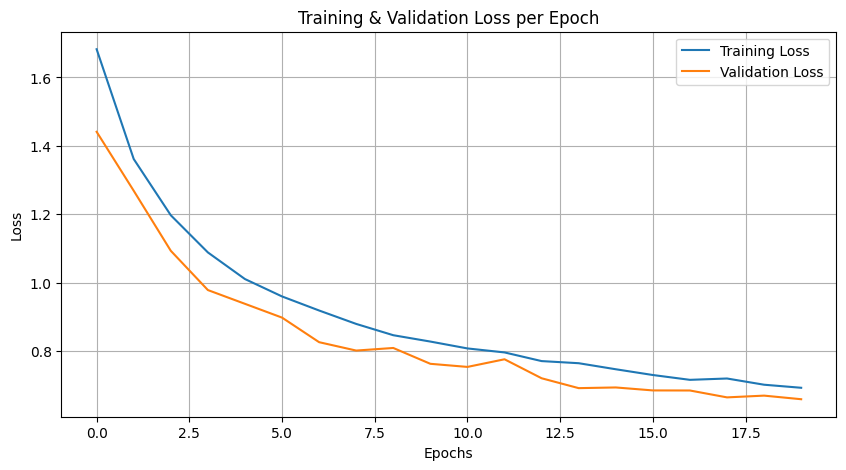

In [ ]:
# ==============================================================================
# STEP 7: PLOTTING THE LOSS HISTORY
# ==============================================================================
print("\nPlotting training and validation loss...")

plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Training & Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# ==============================================================================
# STEP 8: FINAL MODEL TESTING
# ==============================================================================
print("\nStarting final model testing...")
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'\nFinal accuracy of the network on the 10000 test images: {accuracy:.2f} %')


Starting final model testing...

Final accuracy of the network on the 10000 test images: 78.22 %
